# Lab 6: Convolutional Network Architectures
## by Michael Doherty, Leilani Guzman, and Carson Pittman

Link to the dataset: https://www.kaggle.com/datasets/brsdincer/vehicle-detection-image-set

## 1. Preparation
### 1.1 Performance Metric

we start by reading in the data from our vehicle detection Kaggle dataset. These images seem to have been sourced by splitting video, taken from a car in motion, into multiple images that are of other vehicles or of non-vehicles.

In [1]:
import glob
import warnings
from tensorflow.keras.preprocessing.image import load_img, img_to_array

warnings.simplefilter('ignore')

# load in images and labels as numpy arrays
images_and_labels = []

#FIXME just make 2 separate lists later, make labels 0/1 by default??
# FIXME should we make images grayscale??

for filename in glob.glob('data/vehicles/*.png'):
    img = load_img(filename)
    img_array = img_to_array(img)
    
    images_and_labels.append(tuple((img_array, 'vehicle')))
    

for filename in glob.glob('data/non-vehicles/*.png'):
    img = load_img(filename)
    img_array = img_to_array(img)
    
    images_and_labels.append(tuple((img_array, 'non_vehicle')))
    

print('There are', len(images_and_labels), 'images')

There are 17760 images


Now that we've read in the images, let's visualize the distribution of labels for our images.

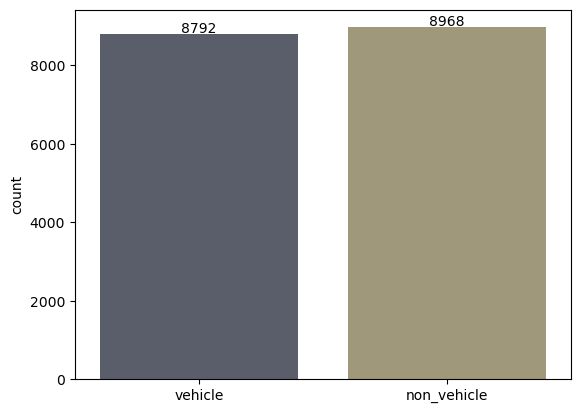

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.countplot(x=[label for _, label in images_and_labels], palette='cividis')

for bar in ax.patches:
    ax.annotate(f'{bar.get_height():.0f}', (bar.get_x() + bar.get_width() / 2., bar.get_height()),
                ha='center', va='center', xytext=(0, 4), textcoords='offset points')

plt.xticks([0,1], ['vehicle', 'non_vehicle'])
plt.show()

As we can see, there are about the same number of instances for each label (<code>non_vehicle</code> has a little less than 200 more instances than <code>vehicle</code>). Because the number of images in both of our classes are so similar, there will be negligible effects from class imbalance. 

Despite accuracy being flawed in many situations, it actually fits our needs for this dataset. Accuracy favors all classes equally which is needed in order to avoid other cars as well as other road hazards while also knowing when there is nothing in the adjacent lane (detecting if it is safe to merge or not). Accuracy also cares about all errors equally, which is important for self-driving vehicles because swerving to avoid a car that is not there is bad (false positives) and colliding with cars the system did not detect is also bad (false negatives). For these reasons, we will use accuracy to determine the value of our networks. Becasue of our use case, our network would need to be more than 99% accurate to be considered usable in a real world self-driving vehicle.

**Dr. Larson said accuracy would be a pretty good metric, as we care about both vehicle and non_vehicle labels (since the business case is self-driving cars, and the images seem to be taken from a car driving on the road, so we would want it to be able to accurately distinguish between the two)**

**Probably should mention somewhere that these images are like a 'patchwork', i.e., they seem to be taken from a larger image that was captured by a car driving on the road**

### 1.2 Training and Testing Method

**Dr. Larson said we don't specifically need to stratify, as the splits will be pretty consistent since the labels are pretty balanced**

**He said this dataset is one of those weird ones where accuracy and not stratifying is actually probably the best solution**

In [3]:
from sklearn.model_selection import train_test_split
import numpy as np

X = [image for image, _ in images_and_labels]
y = [0 if label == 'vehicle' else 1 for _, label in images_and_labels]

X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.2)

# normalize pixel values and mean shift
X_train = X_train/255.0 - 0.5
X_test = X_test/255.0 - 0.5

## 2. Modeling
### 2.1 Data Augmentation
Now that we've defined our performance metric and created training and testing splits for cross validation, let's start creating our Convolutional Neural Networks! Let's start by creating a base for our models that includes some augmentation layers.

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomBrightness

model_base = Sequential()

model_base.add(RandomFlip("horizontal"))
model_base.add(RandomRotation(0.2))
model_base.add(RandomZoom(0.2))
model_base.add(RandomBrightness(0.2))

**Dr. Larson said these Augmentation layers should be used for all of our models (i.e., we shouldn't change them after we initialize them, as it will make comparing models weird)**

**Dr. Larson also said that the 2 big augmentations we don't want to do are RandomFlip("vertical") and randomly rotating by too high a percentage (as even after augmentation, the images should still be something a car could realistically see while driving around on the road, and upside down or sideways cars would not be something the car would see)**

**Justification would be something like: A little bit of random rotation, as cars might be driving up a hill, changing brightness, as cars could be driving at different times of day with different lighting, etc.**

Explain why these augmentation features are appropriate...

### 2.2 Model Creation
Now let's create a few different models using the base structure we just created.

#### 2.2.1 CNN 1: Basic Network

In [5]:
from tensorflow.keras.models import clone_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

cnn_1 = clone_model(model_base)


# The following was copied from Dr. Larson's Notebook (12. More Advanced CNN Techniques)
NUM_CLASSES = 2
img_wh = 64

# let's start with an AlexNet style convolutional phase
cnn_1.add(Conv2D(filters=32,
                input_shape = (img_wh,img_wh,1),
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax

# no max pool before next conv layer!!
cnn_1.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax
cnn_1.add(MaxPooling2D(pool_size=(2, 2)))
    

# add one layer on flattened output
cnn_1.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn_1.add(Flatten())
cnn_1.add(Dense(128, activation='relu'))
cnn_1.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn_1.add(Dense(1, activation='sigmoid'))

# Let's train the model 
cnn_1.compile(loss='binary_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

history_1 = cnn_1.fit(X_train, y_train, batch_size=32, 
                   epochs=5, verbose=1,
                   validation_data=(X_test,y_test)
                  )

Epoch 1/5
444/444 [==============================] - 66s 136ms/step - loss: 1.4796 - accuracy: 0.4995 - val_loss: 0.6770 - val_accuracy: 0.5059
Epoch 2/5
444/444 [==============================] - 57s 129ms/step - loss: 0.7273 - accuracy: 0.5013 - val_loss: 0.8100 - val_accuracy: 0.5121
Epoch 3/5
444/444 [==============================] - 60s 134ms/step - loss: 0.7696 - accuracy: 0.5066 - val_loss: 0.7943 - val_accuracy: 0.5312
Epoch 4/5
444/444 [==============================] - 71s 160ms/step - loss: 0.7776 - accuracy: 0.5050 - val_loss: 0.8833 - val_accuracy: 0.5631
Epoch 5/5
444/444 [==============================] - 72s 163ms/step - loss: 0.7705 - accuracy: 0.5016 - val_loss: 1.0531 - val_accuracy: 0.6419


**Might be able to get rid of all the warnings by upgrading Tensorflow version**

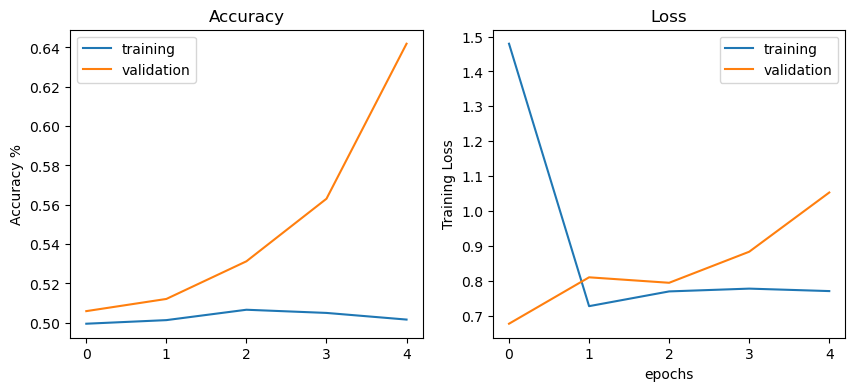

In [8]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_1.history['accuracy'], label='training')

plt.ylabel('Accuracy %')
plt.title('Training')
plt.plot(history_1.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_1.history['loss'], label='training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.plot(history_1.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
plt.show()

#### 2.2.2 CNN 2: Ensemble Network

In [26]:
%%time

from tensorflow.keras.layers import Input, average, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2 

num_ensembles = 3
l2_lambda = 0.0001 # notebook was 0.000001

input_holder = Input(shape=(img_wh,img_wh,3))
print(input_holder.shape)


# Start with a convolutional layer
x = Conv2D(filters=32,
            kernel_size=(3,3),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu', data_format='channels_last')(input_holder)

x = Conv2D(filters=32,
            kernel_size=(3,3),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu')(x)

input_conv = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(x)

branches = []
for _ in range(num_ensembles):
    # Start using NiN (MLPConv)
    x = Conv2D(filters=32,
                input_shape = (img_wh,img_wh,1),
                kernel_size=(3,3),
                kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda),
                padding='same',
                activation='linear', data_format='channels_last')(input_conv)
    
    x = Conv2D(filters=32,
                kernel_size=(1,1),
                kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda),
                padding='same',
                activation='relu', data_format='channels_last')(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(x)

    x = Conv2D(filters=64,
                input_shape = (img_wh, img_wh, 1),
                kernel_size=(3,3),
                kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda),
                padding='same',
                activation='linear', data_format='channels_last')(x)
    
    x = Conv2D(filters=64,
                kernel_size=(1,1),
                kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda),
                padding='same',
                activation='linear', data_format='channels_last')(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(x)

    # Add layer on flattened output
    x = Flatten()(x)
    x = Dropout(0.50)(x) # Add dropout for regularization after convolution layers
    x = Dense(64,
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda))(x)
    
    x = Dense(NUM_CLASSES,
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda))(x)
    
    # Now add this branch to the master list
    branches.append(x)

x = concatenate(branches)

x = Dense(1,
        activation='sigmoid',
        kernel_initializer='glorot_uniform',
        kernel_regularizer=l2(l2_lambda))(x)

# Setting the network using functional API
cnn_ens = clone_model(model_base)
cnn_ens = Model(inputs=input_holder, outputs=x)
cnn_ens.summary()

cnn_ens.compile(loss='binary_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam',
                metrics=['accuracy'])

ens_history = cnn_ens.fit(X_train, y_train, batch_size=32,
                        steps_per_epoch=int(len(X_train)/128), 
                        epochs=5, verbose=0,
                        validation_data=(X_test,y_test),
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
                        )

(None, 64, 64, 3)
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_66 (Conv2D)             (None, 64, 64, 32)   896         ['input_15[0][0]']               
                                                                                                  
 conv2d_67 (Conv2D)             (None, 64, 64, 32)   9248        ['conv2d_66[0][0]']              
                                                                                                  
 max_pooling2d_34 (MaxPooling2D  (None, 32, 32, 32)  0           ['conv2d_67[0][0]']              
 )                                                                        

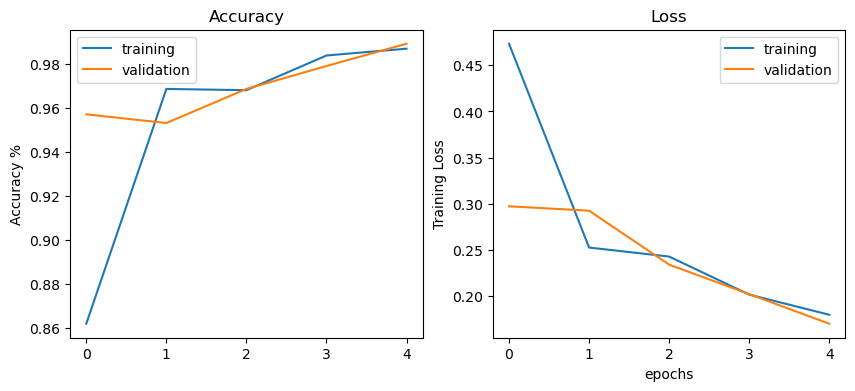

In [27]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(ens_history.history['accuracy'], label='training')

plt.ylabel('Accuracy %')
plt.title('Training')
plt.plot(ens_history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(ens_history.history['loss'], label='training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.plot(ens_history.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
plt.show()

Now lets create another CNN based on this Ensemble Network architecture, but with some modifications of the parameters. 


**COPY ABOVE NETWORK AND MODIFY PARAMETERS**

#### 2.2.3 CNN 3: ResNet Network

In [28]:
%%time
from tensorflow.keras.layers import Add, Activation

input_holder = Input(shape=(img_wh,img_wh,3))

# Start with a convolutional layer
x = Conv2D(filters=32, 
            input_shape = (img_wh,img_wh,3),
            kernel_size=(3,3),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu', data_format='channels_last')(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(x)

x = Conv2D(filters=32,
            kernel_size=(3,3),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu', data_format='channels_last')(x)

x_split = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(x)

x = Conv2D(filters=64,
            kernel_size=(1,1),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu', data_format='channels_last')(x_split)

x = Conv2D(filters=64,
            kernel_size=(3,3),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu', data_format='channels_last')(x)

x = Conv2D(filters=32,
            kernel_size=(1,1),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu', data_format='channels_last')(x)
    

# Add back in the split layer, x_split
x = Add()([x, x_split])
x = Activation('relu')(x)

x = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256)(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(1)(x)
x = Activation('sigmoid')(x)

resnet = clone_model(model_base)
resnet = Model(inputs=input_holder, outputs=x)
resnet.summary()

resnet.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

res_history = resnet.fit(X_train, y_train, batch_size=32,
                        steps_per_epoch=int(len(X_train)/128), 
                        epochs=5, verbose=0,
                        validation_data=(X_test,y_test),
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
                        )

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_80 (Conv2D)             (None, 64, 64, 32)   896         ['input_16[0][0]']               
                                                                                                  
 max_pooling2d_41 (MaxPooling2D  (None, 32, 32, 32)  0           ['conv2d_80[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_81 (Conv2D)             (None, 32, 32, 32)   9248        ['max_pooling2d_41[0][0]'] 

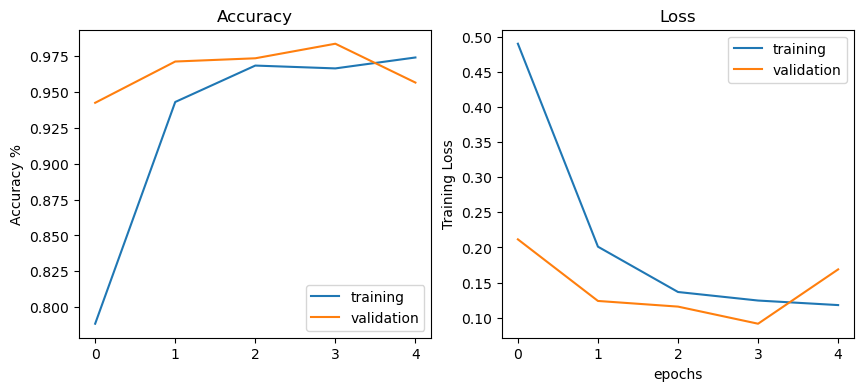

In [29]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(res_history.history['accuracy'], label='training')

plt.ylabel('Accuracy %')
plt.title('Training')
plt.plot(res_history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(res_history.history['loss'], label='training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.plot(res_history.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
plt.show()

Now lets create another CNN based on this ResNet architecture, but with some modifications of the parameters.


**COPY ABOVE NETWORK AND MODIFY PARAMETERS**

### 2.3 Model Visualization and Comparison

### 2.4 Convolutional Network vs. Multi-Layer Perceptron

Now that we've created a few different CNN's, let's compare the best one to a standard MLP. First lets create this MLP and then compare the two models.

In [38]:
# Create a basic multi-layer perceptron model
from tensorflow.keras.layers import Activation

mlp = Sequential()
mlp.add(Flatten(input_shape=(img_wh,img_wh,3)))
mlp.add(Dense(128, activation='relu'))
mlp.add(Dense(64, activation='relu'))
mlp.add(Dense(1))
mlp.add(Activation('sigmoid'))

mlp.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

mlp_history = mlp.fit(X_train, y_train, batch_size=32,
                      steps_per_epoch=int(len(X_train)/128),
                      epochs=5, verbose=0,
                      validation_data=(X_test,y_test),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
                      )

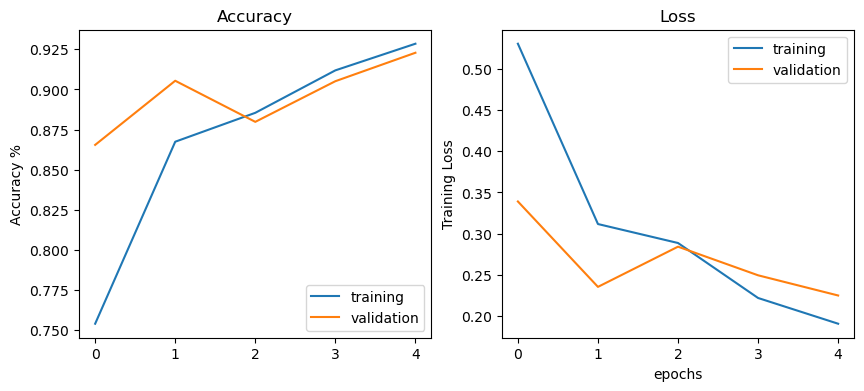

In [39]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(mlp_history.history['accuracy'], label='training')

plt.ylabel('Accuracy %')
plt.title('Training')
plt.plot(mlp_history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(mlp_history.history['loss'], label='training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.plot(mlp_history.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
plt.show()

Now lets compare the MLP and the ResNet CNN [*REPLACE WITH BEST CNN*] by plotting their receiver operating characteristic (ROC) curves and calculating their area under the curve (AUC) values.

111/111 [==============================] - 1s 9ms/step


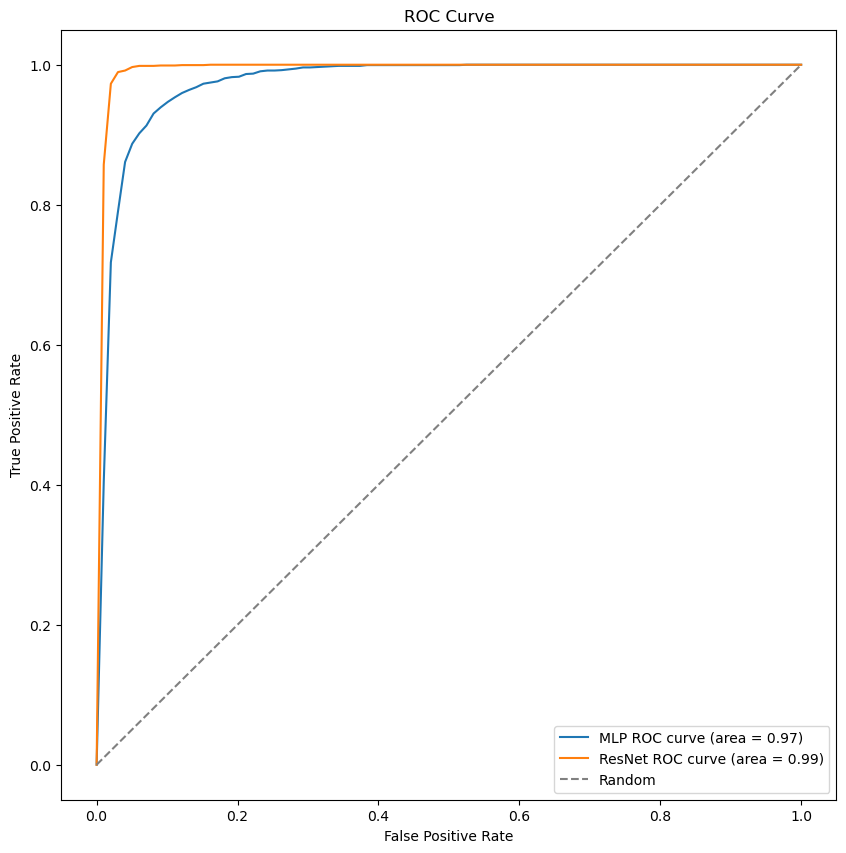

In [41]:
# Compare the ResNet[best] model to the MLP model using receiver operating characteristic (ROC) curves

from sklearn.metrics import roc_curve, auc

mean_fpr = np.linspace(0, 1, 100)

# MLP model
y_pred_mlp = mlp.predict(X_test).ravel()
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, y_pred_mlp)
mean_tpr_mlp = np.interp(mean_fpr, fpr_mlp, tpr_mlp)
mean_tpr_mlp[0] = 0.0
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

# ResNet model
y_pred_res = resnet.predict(X_test).ravel()
fpr_res, tpr_res, thresholds_res = roc_curve(y_test, y_pred_res)
mean_tpr_res = np.interp(mean_fpr, fpr_res, tpr_res)
mean_tpr_res[0] = 0.0
roc_auc_res = auc(fpr_res, tpr_res)

# Plot ROC curves
plt.figure(figsize=(10,10))
plt.plot(mean_fpr, mean_tpr_mlp, label='MLP ROC curve (area = %0.2f)' % roc_auc_mlp)
plt.plot(mean_fpr, mean_tpr_res, label='ResNet ROC curve (area = %0.2f)' % roc_auc_res)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## 3. Transfer Learning
### 3.1 Transfer Learning Model

### 3.2 Model Comparison